In [1]:
import os
import cv2
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D

from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
from matplotlib import pyplot as plt
import imghdr

import imagesize
from PIL import Image

%config Completer.use_jedi = False

In [20]:
 def remove_wrong_picutres(directory_name: str):
    accepted_image_extensions = ['bmp', 'jpg', 'jpeg', 'png']

    for image_directory in os.listdir(directory_name):
        i = 0
        cwd = os.path.join(directory_name, image_directory)
        for image_filename in os.listdir(os.path.join(directory_name, image_directory)):
            image_path = os.path.join(directory_name, image_directory, image_filename)

            img_type = imghdr.what(image_path)
            if img_type is None:
                print("{} is a corrupt image and will be removed.".format(image_path))
                os.remove(image_path)
                continue
            elif img_type not in accepted_image_extensions:
                try:
                    im = Image.open(image_path)
                    im.verify()
                    im = Image.open(image_path).convert('RGB')
                    im.save(f"{cwd}\\{str(i)}.jpeg")

                    print(f"{image_path} was converted successfully.")
                    i = i + 1
                    im.close()
                except Exception:
                    print("{} is a corrupt image and will be removed.".format(image_path))
                    os.remove(image_path)
                    continue

            file_size_kb = os.stat(image_path).st_size / 1024
            if file_size_kb < 16:
                print("{} has too small size and will be removed.".format(image_path))
                os.remove(image_path)
                continue
            
            width, height = imagesize.get(image_path)
            aspect_ratio = max(width, height) / min(width, height)
            if aspect_ratio > 3.6:
                print("{} has too large aspect ratio and will be removed.".format(image_path))
                os.remove(image_path)
                continue

In [70]:
from pathlib import Path
import imghdr

data_dir = "../images_for_ensemble_training/human_recogniser"
image_extensions = [".png", ".jpg", ".jpeg"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is a corrupt image and will be removed.")
            os.remove(filepath)
        elif img_type not in image_extensions:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow. It will be removed.")
            os.remove(filepath)

images_for_ensemble_training\human_recogniser\invalid\07.jpg is a corrupt image and will be removed.
images_for_ensemble_training\human_recogniser\invalid\65221d14924611.5628ab7811ac1.jpg is a corrupt image and will be removed.
images_for_ensemble_training\human_recogniser\invalid\b8e3b214924611.5628acc831f6c.jpg is a corrupt image and will be removed.
images_for_ensemble_training\human_recogniser\invalid\depositphotos_87681198-stock-illustration-sports-car-outlines-modern-car.jpg is a webp, not accepted by TensorFlow. It will be removed.
images_for_ensemble_training\human_recogniser\invalid\en-use-202103-bb16c30833508e34d5bbbe5ae8bff803.jpg is a corrupt image and will be removed.
images_for_ensemble_training\human_recogniser\invalid\smiling-cat-drawing-butterfly-web.jpg is a corrupt image and will be removed.


In [ ]:
remove_wrong_picutres('../images_for_ensemble_training/animal_recogniser')

In [29]:
dataset_directory = os.path.join('../images_for_ensemble_training/human_recogniser')
data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory, batch_size=32, image_size=(256, 256))

Found 10130 files belonging to 2 classes.


In [30]:
iterator = data.as_numpy_iterator()

In [31]:
batch = iterator.next()

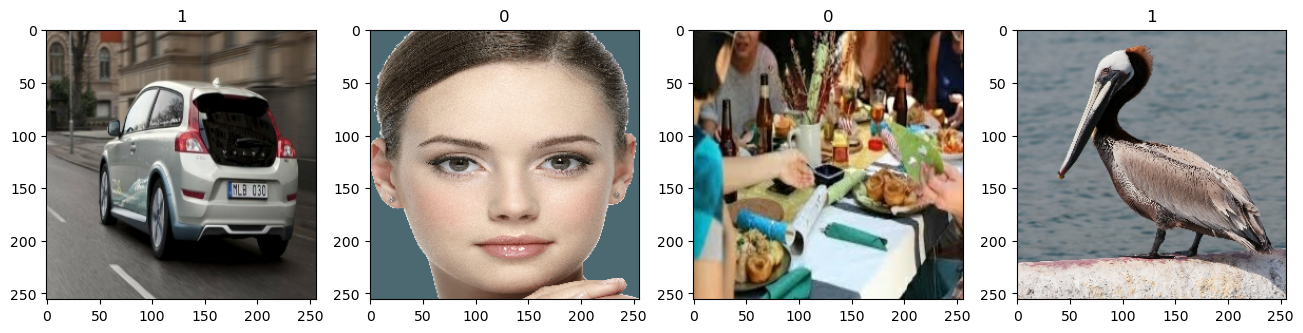

In [32]:
figure, ax = plt.subplots(ncols=4, figsize=(16, 16))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [33]:
data = data.map(lambda x, y: (x / 255, y))
scaled_iterator = data.as_numpy_iterator()

In [34]:
batch_count = len(data)
train_size = int(batch_count * 0.7)
test_size = int(batch_count * 0.1)
validation_size = int(batch_count * 0.2)

In [35]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)
validation_data = data.skip(train_size).skip(test_size).take(validation_size)

In [53]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 2, padding="same", input_shape=(256,256,3), activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), 2, padding="valid", activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3), 1, padding="same", activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

In [54]:
model.compile(tf.keras.optimizers.Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
log_directory = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [58]:
import datetime
now = datetime.datetime.now()
formatted_date = str("{}-{}-{}-{}-{}-{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second))
model_checkpoint = ModelCheckpoint('../saved_models\\ensemble_training\\human_recogniser\\test5-'+ formatted_date + '.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [59]:
history = model.fit(train_data, epochs=25, validation_data=validation_data, callbacks=[tensorboard_callback, early_stopping, model_checkpoint])

Epoch 1/25
221/221 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.6848
Epoch 1: val_loss improved from inf to 0.50070, saving model to saved_models\ensemble_training\human_recogniser\test5-2023-2-10-16-33-53.h5
221/221 [==============================] - 65s 292ms/step - loss: 0.5884 - accuracy: 0.6848 - val_loss: 0.5007 - val_accuracy: 0.7589
Epoch 2/25
221/221 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.7593
Epoch 2: val_loss improved from 0.50070 to 0.47669, saving model to saved_models\ensemble_training\human_recogniser\test5-2023-2-10-16-33-53.h5
221/221 [==============================] - 65s 294ms/step - loss: 0.4919 - accuracy: 0.7593 - val_loss: 0.4767 - val_accuracy: 0.7753
Epoch 3/25
221/221 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.7951
Epoch 3: val_loss improved from 0.47669 to 0.41287, saving model to saved_models\ensemble_training\human_recogniser\test5-2023-2-10-16-33-53.h5
221/221 [=======

In [60]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()

In [61]:
for batch in test_data.as_numpy_iterator():
    x, y = batch
    one_hot_y = tf.one_hot(indices=y, depth=2)
    yhat = model.predict(x)
    precision.update_state(one_hot_y, yhat)
    recall.update_state(one_hot_y, yhat)
    accuracy.update_state(one_hot_y, yhat)

In [62]:
print("Precision: {}".format(precision.result().numpy()))
print("Recall: {}".format(recall.result().numpy()))
print("Accuracy: {}".format(accuracy.result().numpy()))

Precision: 0.8840726017951965
Recall: 0.8840726017951965
Accuracy: 0.8840726017951965


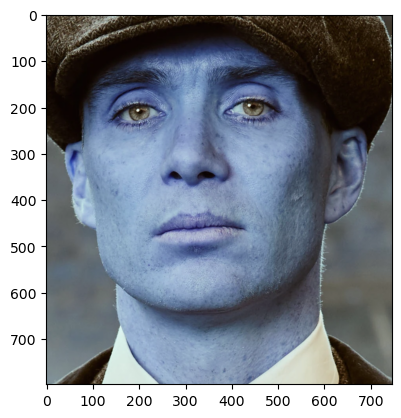

In [145]:
test_image = cv2.imread('../test_images/11.PNG')
plt.imshow(test_image)
plt.show()

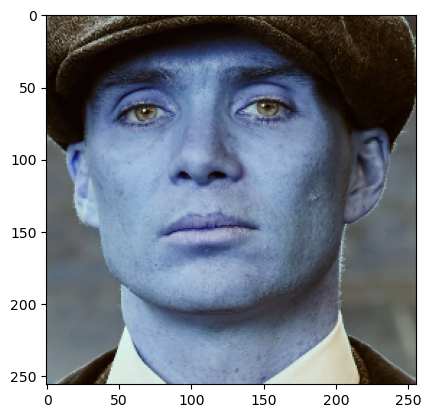

In [146]:
resized_image = tf.image.resize(test_image, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [147]:
yhat = model.predict(np.expand_dims(resized_image / 255, 0))

In [148]:
yhat_list = yhat.tolist()[0]
print(yhat_list)
print("Prediction: category {}. Possibility: {}".format(yhat_list.index(max(yhat_list)), round(max(yhat_list), ndigits=4)))

[3.9195823774207383e-05, 0.9999607801437378]
Prediction: category 1. Possibility: 1.0
